In [1]:
import tike.ptycho
import numpy as np
import matplotlib.pyplot as plt
import importlib

/home/beams/B242827/miniconda3/envs/tike/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [2]:
for module in [tike, np]:
    print("{} is version {}".format(module.__name__, module.__version__))

tike is version 0.5.1.dev7+g38f8565.d20181109
numpy is version 1.15.2


# Create test data

Make a test data for pytchography reconstruction at one projection angle.

### Define the object

Normalize input uint8 images to the `[0, 1]` and `[0, pi]` ranges.

In [3]:
amplitude = plt.imread("../tests/data/Cryptomeria_japonica-0128.tif") / 255
phase = plt.imread("../tests/data/Bombus_terrestris-0128.tif") / 255 * np.pi
np.min(phase), np.max(phase)

(0.036959913571644624, 3.129272682399245)

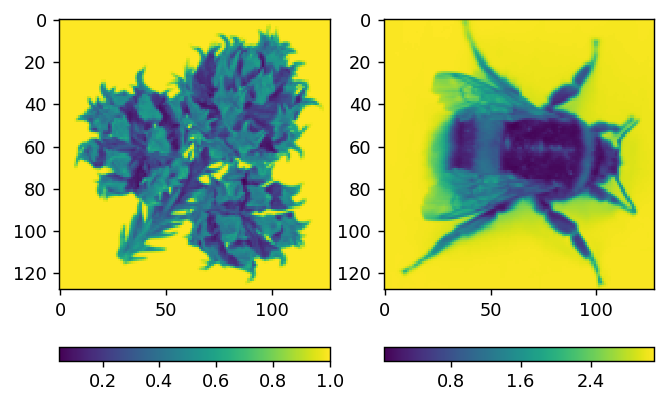

(128, 128)

(-0.9999241101148306+0.012319659535238529j) (0.9951469164070644+0.0984002782796427j)


In [4]:
original = amplitude * np.exp(1j * phase)
tike.plot_phase(original)
original.shape

### Define the probe

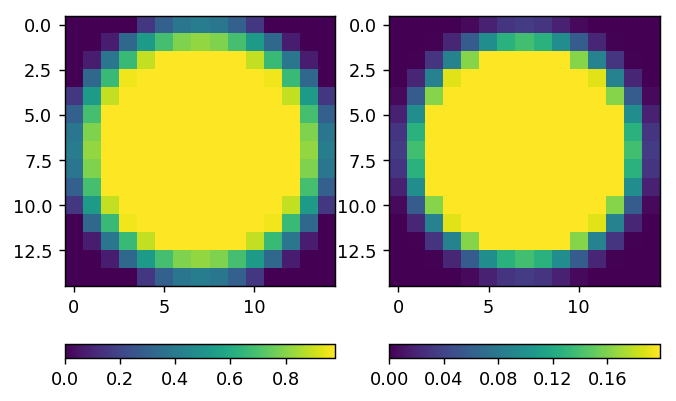

In [5]:
pw = 15 # probe width
weights = tike.ptycho.gaussian(pw, rin=0.8, rout=1.0)
probe = weights * np.exp(1j * weights * 0.2)
tike.plot_complex(probe)

### Define the trajectory

In [6]:
v, h = np.meshgrid(
    np.linspace(0, amplitude.shape[0]-pw, 24, endpoint=False),
    np.linspace(0, amplitude.shape[0]-pw, 24, endpoint=False),
    indexing='ij'
    )
print(v.shape, h.size)

(24, 24) 576


## Simulate data acquisition

In [7]:
# Then what we see at the detector is the wave propagation
# of the near field wavefront
data = tike.ptycho.simulate(data_shape=np.ones(2, dtype=int)*pw*3,
                            probe=probe, v=v, h=h,
                            psi=original)
data.shape

(576, 45, 45)

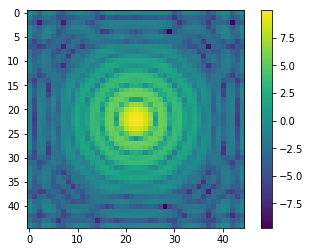

(1.3872756e-07, 21374.846)

In [8]:
plt.imshow(np.fft.fftshift(np.log(data[11])))
plt.colorbar()
plt.show()
np.min(data), np.max(data)

# Reconstruct

Now we need to try and reconstruct psi.

In [9]:
# Start with a guess of all zeros for psi
new_psi = np.ones(original.shape, dtype=complex)

INFO:tike.ptycho:grad on 576 - 45 by 45 grids for 1 iterations


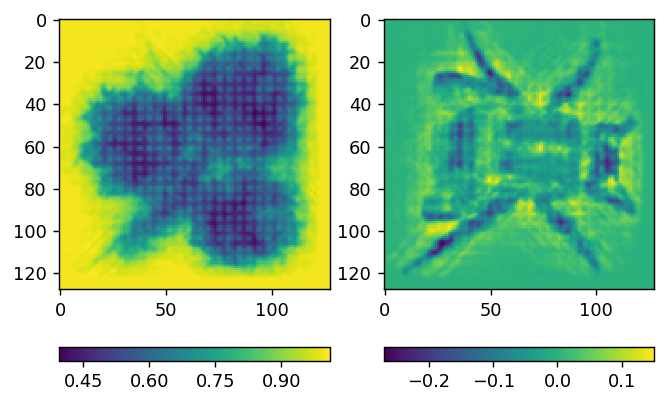

INFO:tike.ptycho:grad on 576 - 45 by 45 grids for 1 iterations


(0.39496022+0.020489018j) (1.0099547+0.0027011035j)


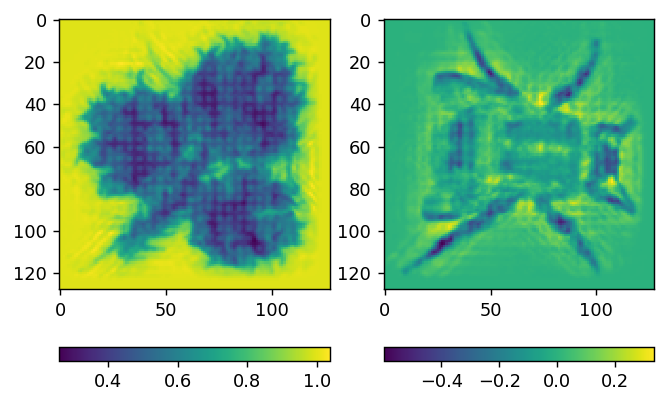

INFO:tike.ptycho:grad on 576 - 45 by 45 grids for 1 iterations


(0.24907637-0.06919874j) (1.0311273+0.079533294j)


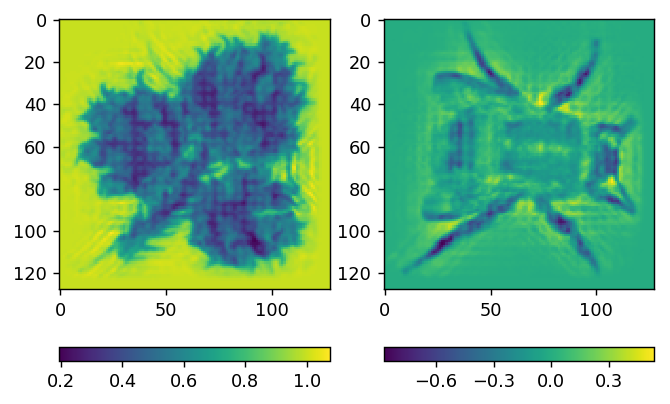

INFO:tike.ptycho:grad on 576 - 45 by 45 grids for 1 iterations


(0.16790509-0.097187385j) (1.0523378+0.10143146j)


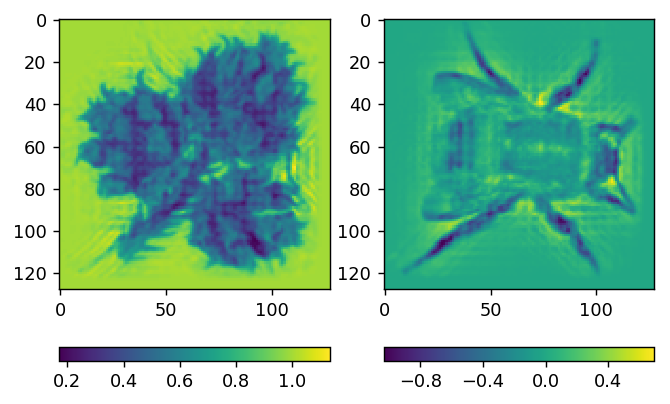

INFO:tike.ptycho:grad on 576 - 45 by 45 grids for 1 iterations


(0.1272779-0.11325897j) (1.0913538-0.19152892j)


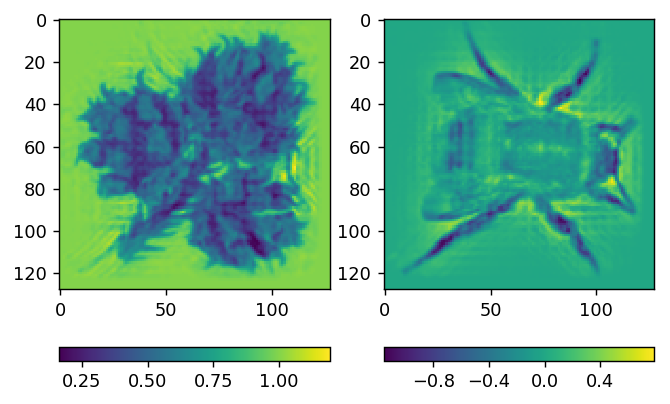

INFO:tike.ptycho:grad on 576 - 45 by 45 grids for 1 iterations


(0.11108604-0.12073233j) (1.1487303+0.0468537j)


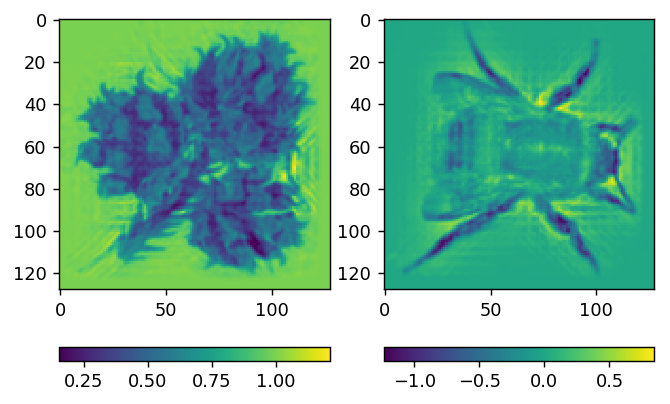

INFO:tike.ptycho:grad on 576 - 45 by 45 grids for 1 iterations


(0.105868354-0.11224259j) (1.1824313+0.038952895j)


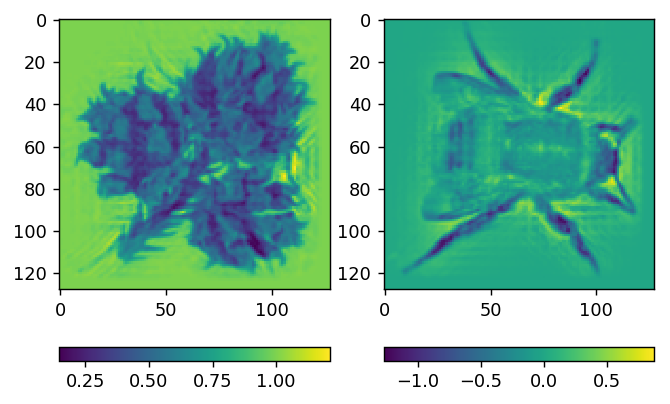

INFO:tike.ptycho:grad on 576 - 45 by 45 grids for 1 iterations


(0.09517514-0.124829486j) (1.2009605+0.02538055j)


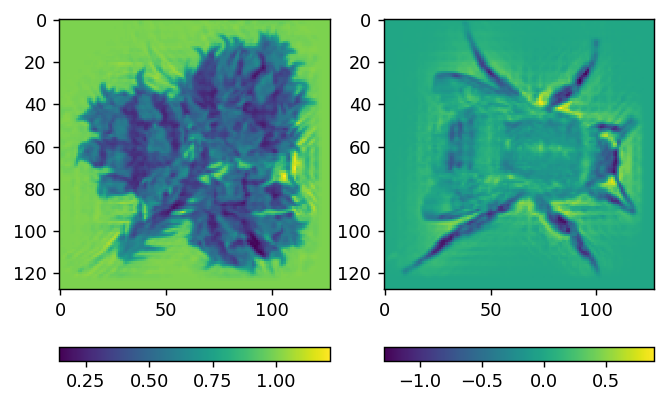

INFO:tike.ptycho:grad on 576 - 45 by 45 grids for 1 iterations


(0.09041571-0.12093472j) (1.2106714+0.009925934j)


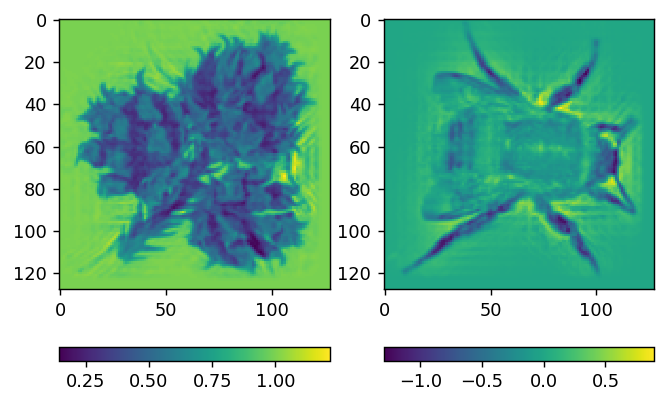

INFO:tike.ptycho:grad on 576 - 45 by 45 grids for 1 iterations


(0.08951204-0.118112236j) (1.2143816-0.0064972397j)


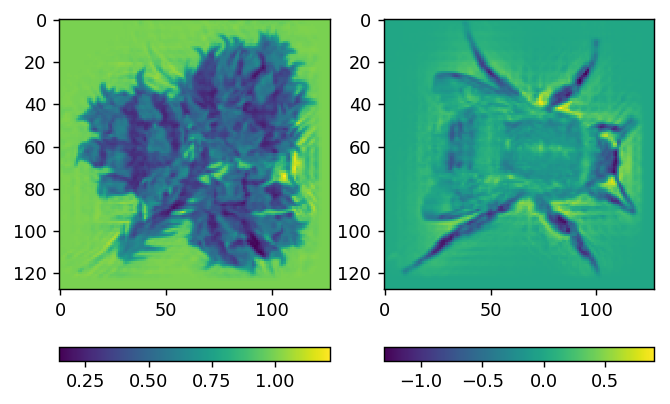

(0.09055277-0.11628706j) (1.2154689-0.022629496j)


In [11]:
for i in range(10):
    new_psi = tike.ptycho.reconstruct(data=data,
                                      probe=probe, v=v, h=h,
                                      psi=new_psi,
                                      algorithm='grad',
                                      num_iter=1, rho=0.5, gamma=0.25)
    tike.plot_phase(new_psi)